## Run comments

<a href="https://confluence.desy.de/display/FLASH/2021+25+and+27+August++Beamtime" >Link to Confluence page</a>

### Essential cells

- [Setting the path to load and save the data](#load)
- [Obtaining the spctrum of reference and streaked pulse](#spec)
- [Check spectral range](#check)
- [Arrival time sorting](#arrival)
- [FWHM calculation - reference and streaked pulse](#fwhm)
- [Pulse duration calculation - mean and std](#pulse)
- [Correlation plots](#correlation)

### Extra cells

- [Finding the Best threshold for relative arrival time](#rel_arrival)
- [Ploting the fitting parameters](#fit_param)
- [Ploting fitting curves](#fit_curve)
- [Ploting traces](#traces)

In [84]:
import h5py
import scipy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Iterable, Optional, Dict, Union
from pandas import Series, DataFrame
import pandas as pd
from scipy.optimize import curve_fit
import glob
from scipy.signal import savgol_filter
from scipy import integrate
import matplotlib.gridspec as gridspec
from skimage.measure import block_reduce
from os import path as path_func
import os
from matplotlib.ticker import MaxNLocator
from PIL import Image, ImageDraw
import static_functions as sfun
from scipy.stats import gaussian_kde
import statistics
from cycler import cycler
from scipy import stats
import math
import seaborn as sns

# Setting the global parameters for plottings 

plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['ytick.major.pad'] = 0.5
plt.rcParams['xtick.major.pad'] = 2.5
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams["figure.figsize"] = [10, 5]
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
#plt.rcParams["figure.figsize"] = (6,10)

######################## eV/fs  this value must change from run to run

# streaking speed for 34 nm measurement - 25 Aug
#str_slope_tof1 = 37.8/1000  
#str_slope_tof2 = 29.6/1000

# streaking speed for 34 nm measurement - 25 Aug
#str_slope_tof1 = 42.8/1000  
#str_slope_tof2 = 36.6/1000

# streaking speed for 34 nm measurement - 25 Aug - taken from run 39922
str_slope_tof1 = 28.15/1000  
str_slope_tof2 = 24.25/1000

# streaking speed for 34 nm measurement - 27 Aug
#str_slope_tof1 = 22.98/1000  
#str_slope_tof2 = 23.34/1000

# streaking speed for 34 nm measurement - 1 Sep - taken from run 40129
#str_slope_tof1 = 80.75/1000  
#str_slope_tof2 = 68.76/1000

### Setting the path to __load__ and __save__ the data
<a id="load"></a>

In [2]:
file_num = 1
run_number = 'run39924'
path =      '/asap3/flash/gpfs/fl21/2021/data/11012601/raw/hdf/Aug25/'
save_path = '/asap3/flash/gpfs/fl21/2021/data/11012601/processed/Analysis results/Static runs/'
file_path = sfun.get_path(run_number,path,file_num)

with h5py.File(file_path, 'r') as h5_file:
    adc_data1 = sfun.dset_data_frame(h5_file["FL2/Experiment/FL21/ADQ412 GHz ADC/CH00/TD"])   #address of the adc (tof data)
    adc_data2 = sfun.dset_data_frame(h5_file["FL2/Experiment/FL21/ADQ412 GHz ADC/CH02/TD"])
    laser_delay_data = sfun.dset_data_frame(h5_file["FL2/Experiment/FL21/Laser/streaking delayline pos"])
    #retardation_voltage_data = sfun.dset_data_frame(h5_file["FL2/Experiment/FL21/TOF/retardation voltage readback 1"])
    retardation_voltage_data = sfun.dset_data_frame(h5_file["/uncategorised/FLASH.FEL/FL21.VACUUM/BEAMLINE/OPCUA.PRG_Beamline.fbTOF1.fRetVoltV"])
    sample_frequency_data1 = sfun.dset_data_frame(h5_file["FL2/Experiment/FL21/ADQ412 GHz ADC/CH00/sample frequency"])
    sample_frequency_data2 = sfun.dset_data_frame(h5_file["FL2/Experiment/FL21/ADQ412 GHz ADC/CH02/sample frequency"])
    #polarix_data = sfun.dset_data_frame(h5_file["/uncategorised/FLASH.DIAG/CAMERA/OTR9FL2XTDS"])
    #gmd_hall = sfun.dset_data_frame(h5_file["/FL2/Photon Diagnostic/GMD/Pulse resolved energy/energy hall"])
    #BAM_low = sfun.dset_data_frame(["/FL2/Electron Diagnostic/BAM/8FL2XTDS/electron bunch arrival time (high charge)"])

# the path in which the outputs are saved:
try:
    os.mkdir(save_path + run_number +f'_file{file_num}/')
except OSError:
    pass
os.chdir(save_path + run_number +f'_file{file_num}/')

In [3]:
#test code for BAM
import flashdaqhdfutils as fdu

run_number = 39924
daq = "fl2user1"
directory_path = '/asap3/flash/gpfs/fl21/2021/data/11012601/raw/hdf/Aug25/'

all_files_of_run = fdu.run_files(run_number, directory=directory_path, daq="fl2user1")

dset_names = {"/FL2/Experiment/FL21/ADQ412 GHz ADC/CH00/TD":"adc_data1",
              "/FL2/Experiment/FL21/ADQ412 GHz ADC/CH02/TD":"adc_data2",
              "/FL2/Experiment/FL21/Laser/streaking delayline pos":"laser_delay_data",
              "/FL2/Electron Diagnostic/BAM/8FL2XTDS/electron bunch arrival time (low charge)": "BAM - 8FL2XTDS",
              "FL1/Electron Diagnostic/BAM/4DBC3/electron bunch arrival time (low charge)" : "BAM - 4DBC3", } 

df = fdu.files_dsets_data_frame(all_files_of_run, dset_names)
df['laser_delay_data'] = df['laser_delay_data'].interpolate(method='linear')
df = df.dropna()
df = df[pd.notnull(df["adc_data1"])]
bunchID= df["BAM - 8FL2XTDS"].index
adc_matrix_data = df["adc_data1"].to_numpy()
adc_matrix_data2 = df["adc_data2"].to_numpy()
delay=df["laser_delay_data"].to_numpy()

#BAM data:
df["BAM - 8FL2XTDS clean"] = df["BAM - 8FL2XTDS"].apply(lambda x : x[np.logical_and(x>-10, x<=-1)]) 
df["BAM - 4DBC3 clean"] = df["BAM - 4DBC3"].apply(lambda x : x[np.logical_and(x>-5, x<=0)]) 
df["BAM - 8FL2XTDS mean"] = df["BAM - 8FL2XTDS clean"].apply(np.mean)
df["BAM - 4DBC3 mean"] = df["BAM - 4DBC3 clean"].apply(np.mean)

df = df.drop(columns=["BAM - 8FL2XTDS"])
df = df.drop(columns=["BAM - 4DBC3"])

### Obtaining the __spctrum__ of reference and streaked pulse
<a id="spec"></a>

In [4]:
energy_calibration_parameters=([ 1.99774128e+05, -9.98000000e+02,  4.50000000e+01])
distance = 3590 #this number shouldn't be changed, it is the fixed distance of the reference and streaked pulse
sample_str_min = 3800  # min sample number of the streaked trace
sample_ref_min = sample_str_min + distance # min sample number of the reference trace (next bunch)
width=400 #the width of the range for the ref and str pulse
sample_str_max = sample_str_min + width
sample_ref_max = sample_ref_min + width

reference_signal, streaked_signal, energy_data, no_bck, s_rate = sfun.stat_str(
    adc_data1,laser_delay_data,retardation_voltage_data,sample_frequency_data1,'_tof1_',sample_str_min,sample_ref_min,width,energy_calibration_parameters)
reference_signal2, streaked_signal2, energy_data2, no_bck2, s_rate2 = sfun.stat_str(
    adc_data2,laser_delay_data,retardation_voltage_data,sample_frequency_data2,'_tof2_',sample_str_min,sample_ref_min,width,energy_calibration_parameters)

energy_axis = energy_data[sample_str_min:sample_str_max]
energy_axis2 = energy_data2[sample_str_min:sample_str_max]

last_shot = len(adc_data1) # this line is to remove the last shots in which the shutter is closed
#last_shot = 5800 
first_shot = 0
#last_shot = 700 #defualt value is len(adc_data1)
reference_signal = reference_signal[:,first_shot:last_shot]
streaked_signal = streaked_signal[:,first_shot:last_shot]
reference_signal2 = reference_signal2[:,first_shot:last_shot]
streaked_signal2 = streaked_signal2[:,first_shot:last_shot]

### Check spectral range
<a id="check"></a>

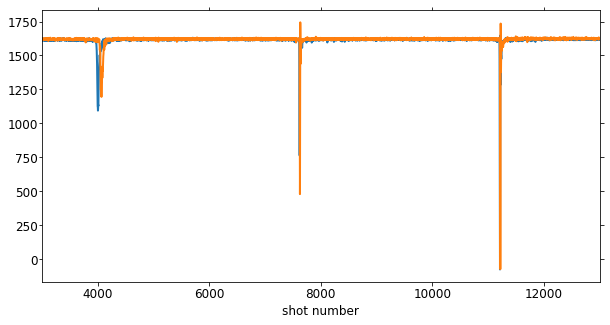

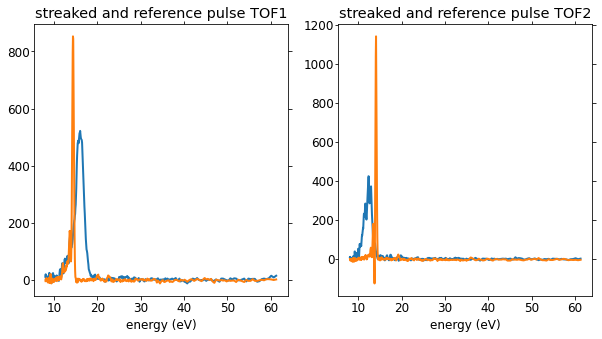

In [5]:
s_min = 0    # min sample number of the adc
s_max = 15000   # max sample number of the adc
shot_num = 62 # it's a random shot to only see if the range is correct

# this line is to get the right range for the first FEL pulse recorded by TOF1 and TOF2
raww = sfun.data2matrixarray(adc_data1.to_numpy(), s_min, s_max)
raww2 = sfun.data2matrixarray(adc_data2.to_numpy(), s_min, s_max)

plt.plot(raww[shot_num])
plt.plot(raww2[shot_num])
plt.xlim(3000,13000)
plt.xlabel("shot number")
plt.show()

plt.subplot(1, 2, 1)
plt.plot(energy_axis,streaked_signal[:,shot_num])  #str spectrum TOF1 in energy domain
plt.plot(energy_axis,reference_signal[:,shot_num])
plt.title("streaked and reference pulse TOF1")
plt.xlabel('energy (eV)')

plt.subplot(1, 2, 2)
plt.plot(energy_axis2,streaked_signal2[:,shot_num])  #str spectrum TOF2 in energy domain
plt.plot(energy_axis2,reference_signal2[:,shot_num])
plt.title("streaked and reference pulse TOF2")
plt.xlabel('energy (eV)')
plt.show()

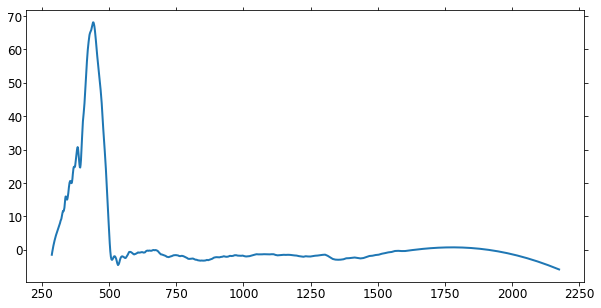

In [7]:
data_ID = 1476
data_matrix_no_background = sfun.remove_background(df["adc_data2"].iloc[data_ID][sample_str_min:sample_str_max])

plt.plot(energy_axis/str_slope_tof1,scipy.signal.savgol_filter(data_matrix_no_background, 71,3))
plt.show()


In [18]:
center_of_gravity1 = [] #value measured from TOF1
center_of_gravity2 = [] #value measured from TOF2

shot_num = np.linspace(0,len(df["adc_data1"]),len(df["adc_data1"]))

for data_ID in range(0,len(df["adc_data1"])):

    data_no_background1 = scipy.signal.savgol_filter(sfun.remove_background(df["adc_data1"].iloc[data_ID][sample_str_min:sample_str_max]), 71,3)
    data_no_background2 = scipy.signal.savgol_filter(sfun.remove_background(df["adc_data2"].iloc[data_ID][sample_str_min:sample_str_max]), 71,3)
    center_of_gravity1.append(np.sum(energy_data[sample_str_min:sample_str_max]*data_no_background1)/(np.sum(data_no_background1)*str_slope_tof1))
    center_of_gravity2.append(np.sum(energy_data2[sample_str_min:sample_str_max]*data_no_background2)/(np.sum(data_no_background2)*str_slope_tof2))


### Arrival time sorting
<a id="arrival"></a>

maximum relative arrival time: 40
total number:               762
number of temporal inliers: 751


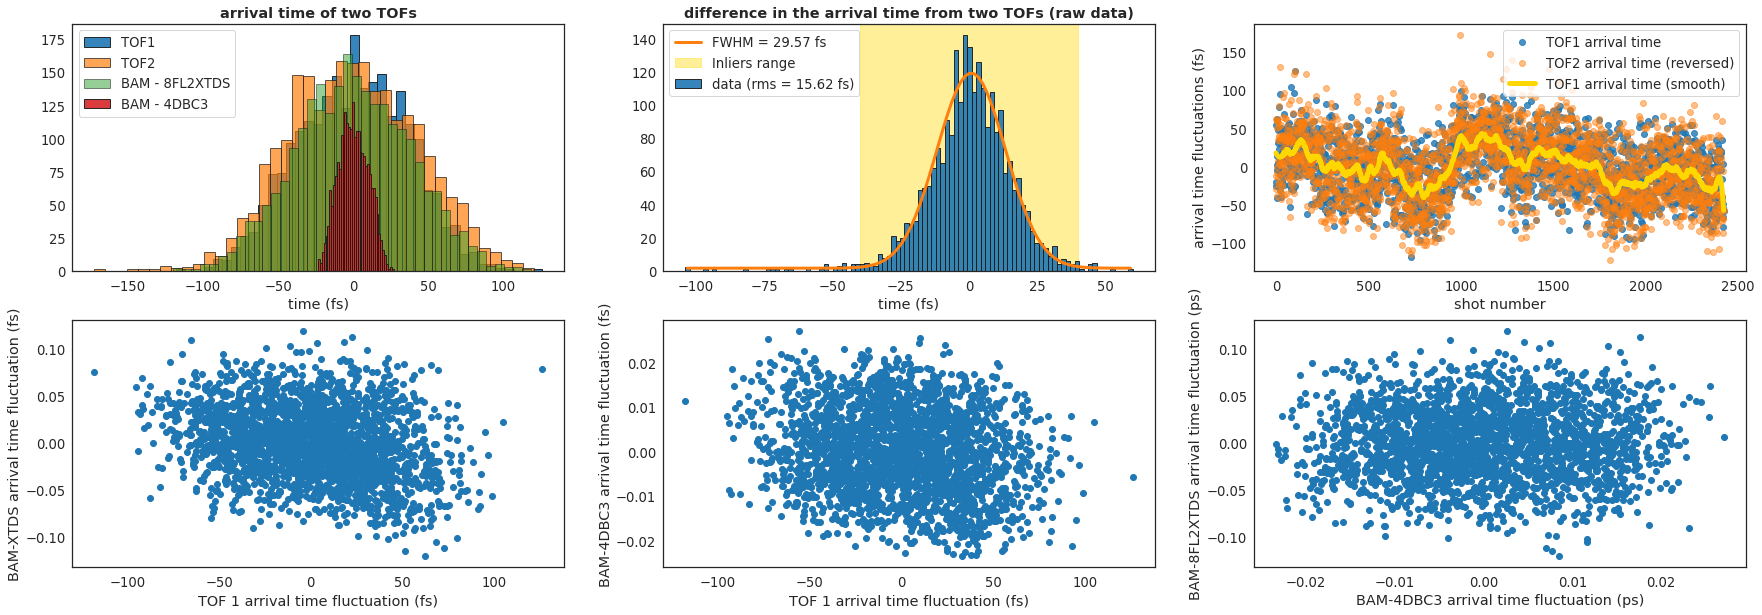

In [140]:
# this cell is to sort out the spectra with big difference in arrival times

max_rel_arrival_time = 40 
print("maximum relative arrival time:",max_rel_arrival_time)
cg1,cg2,difference,temporal_inliers,cg1_fluc,cg2_fluc,reversed_cg2,difference = sfun.temporal_sorter(sample_str_min , sample_str_max , width , no_bck[:,first_shot:last_shot] , no_bck2[:,first_shot:last_shot] , max_rel_arrival_time , energy_axis , str_slope_tof1 , str_slope_tof2)
difference = center_of_gravity1-np.mean(center_of_gravity1)-(np.mean(center_of_gravity2)-center_of_gravity2)
arrival_res = np.std(difference)

#### PLOTS ####
plt.rcParams["figure.figsize"] = [30,10]
plt.subplot(2,3,1)
plt.hist(center_of_gravity1-np.mean(center_of_gravity1) , bins=40 ,edgecolor='k',alpha=0.9,label='TOF1')#or instead we can plot cg1 and cg2
plt.hist(center_of_gravity2-np.mean(center_of_gravity2) , bins=40 ,edgecolor='k', alpha=0.7,label='TOF2')
plt.hist(df["BAM - 8FL2XTDS mean"].sub(df["BAM - 8FL2XTDS mean"].mean()).mul(1000), bins=40 ,edgecolor='k', alpha=0.5,label='BAM - 8FL2XTDS')
plt.hist(df["BAM - 4DBC3 mean"].sub(df["BAM - 4DBC3 mean"].mean()).mul(1000), bins=40 ,edgecolor='k', alpha=0.9,label='BAM - 4DBC3')
plt.title("arrival time of two TOFs", fontweight='bold')
plt.xlabel('time (fs)')
plt.legend()

plt.subplot(2,3,2)
plt.axvspan(-max_rel_arrival_time,max_rel_arrival_time,color ='gold', alpha=0.4,label='Inliers range')
bin_heights, bin_borders, _ = plt.hist(difference , bins=100 ,edgecolor='k', alpha=0.9 , label='data (rms = %s fs)'%round(arrival_res,2))
#bin_heights, bin_borders, _ =plt.hist(,bins=100 ,edgecolor='k', alpha=0.9, label='data (rms = %s fs)'%round(arrival_res,2))
plt.title("difference in the arrival time from two TOFs (raw data)", fontweight='bold')
plt.xlabel('time (fs)')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
[H_hist, A_hist, x0_hist, sigma_hist], _ = sfun.gauss_fit(bin_centers, bin_heights, np.max(bin_heights), bin_centers[np.argmax(bin_heights)], 2)
plt.plot(bin_centers,sfun.gauss(bin_centers, H_hist, A_hist, x0_hist, sigma_hist), label='FWHM = %s fs'%round(sigma_hist*2.3548,2),linewidth=3.0)
plt.legend()

plt.subplot(2,3,3)
plt.plot(shot_num,center_of_gravity1-np.mean(center_of_gravity1),'o',label="TOF1 arrival time",alpha=0.8)
plt.plot(shot_num,np.mean(center_of_gravity2)-center_of_gravity2,'o',label="TOF2 arrival time (reversed)",alpha=0.5)
plt.plot(shot_num,scipy.signal.savgol_filter(center_of_gravity1-np.mean(center_of_gravity1),71,3),label="TOF1 arrival time (smooth)",color ='gold',linewidth=5.0)
plt.xlabel("shot number")
plt.ylabel("arrival time fluctuations (fs)")
plt.legend()

plt.subplot(2,3,4)
plt.plot(center_of_gravity1-np.mean(center_of_gravity1),df["BAM - 8FL2XTDS mean"]-df["BAM - 8FL2XTDS mean"].mean(),'o')
plt.xlabel("TOF 1 arrival time fluctuation (fs)")
plt.ylabel("BAM-XTDS arrival time fluctuation (fs)")

plt.subplot(2,3,5)
plt.plot(center_of_gravity1-np.mean(center_of_gravity1),df["BAM - 4DBC3 mean"]-df["BAM - 4DBC3 mean"].mean(),'o')
plt.xlabel("TOF 1 arrival time fluctuation (fs)")
plt.ylabel("BAM-4DBC3 arrival time fluctuation (fs)")

plt.subplot(2,3,6)
plt.plot(df["BAM - 4DBC3 mean"]-df["BAM - 4DBC3 mean"].mean(),df["BAM - 8FL2XTDS mean"]-df["BAM - 8FL2XTDS mean"].mean(),'o')
plt.xlabel("BAM-4DBC3 arrival time fluctuation (ps)")
plt.ylabel("BAM-8FL2XTDS arrival time fluctuation (ps)")

#plt.savefig(f"{run_number}_arrival_time.png",dpi=300)
plt.show()
plt.rcParams["figure.figsize"] = [10, 5]

### __FWHM calculation__ - reference and streaked pulse
<a id="fwhm"></a>

ref mean - TOF1: 14.315456459870099
str mean - TOF1: 14.621718165685717
ref mean - TOF2: 14.019428527106259
str mean - TOF2: 13.510943732742817


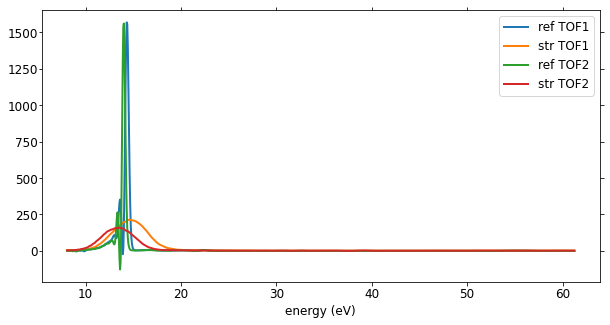

total number of shots:                        762
number of fitting inliers - TOF1:             721
number of fitting inliers - TOF2:             501
number of total fitting inliers:              480
number of total fitting and temporal inliers: 475


In [8]:
#calculation of the mean value for the averaged spectrum:
mean_ref1, mean_str1, amp_ref1, amp_str1 = sfun.mean_calculator(energy_axis,reference_signal,streaked_signal,1)
mean_ref2, mean_str2, amp_ref2, amp_str2 = sfun.mean_calculator(energy_axis2,reference_signal2,streaked_signal2,2)
#plt.savefig(f"{run_number}_averaged_spectrum.png")
plt.show()

def fitting_sorter(energy_axis,reference,streaked,amp_threshold=10,base_threshold=10,sigma_ref_threshold=0,sigma_str_threshold=1): #threshold values are to sort out the fitting outliers 
    
    sigma_ref_list,amplitude_ref_list,base_ref_list,err_ref_list,fit_integ_ref_list,x0_ref_list = [],[],[],[],[],[]
    sigma_str_list,amplitude_str_list,base_str_list,err_str_list,fit_integ_str_list,x0_str_list = [],[],[],[],[],[]
    fitting_inliers = []

    for i in range(0,len(reference[1,:])):

        try:
            [H_ref, A_ref, x0_ref, sigma_ref], pcov_ref = sfun.gauss_fit(energy_axis, reference[:,i], np.max(reference[:,i]), energy_axis[np.argmax(reference[:,i])], 2) #for reference spectrum TOF1
        except RuntimeError:
            [H_ref, A_ref, x0_ref, sigma_ref], pcov_ref = [0,0,0,0],[0,0]
        try:
            [H_str, A_str, x0_str, sigma_str], pcov_str = sfun.gauss_fit(energy_axis, streaked[:,i], np.max(streaked[:,i]), energy_axis[np.argmax(streaked[:,i])], 5) #for streaked spectrum TOF1
        except RuntimeError:
            [H_str, A_str, x0_str, sigma_str], pcov_str = [0,0,0,0],[0,0]
        

        # here I filter outliers (based on the baseline and amplitude of the gaussian peak)
        if  A_ref>amp_threshold and A_str>amp_threshold and 0<H_str and 0<H_ref and sigma_str>sigma_ref and sigma_str*2.35>sigma_str_threshold and sigma_ref*2.35>sigma_ref_threshold:
            fitting_inliers.append(1)
        else:
            fitting_inliers.append(0)

        amplitude_ref_list.append(A_ref)
        base_ref_list.append(H_ref)
        sigma_ref_list.append(np.abs(sigma_ref*2.35))
        x0_ref_list.append(x0_ref)
        err_ref_list.append(np.sqrt(np.diag(pcov_ref)))
        fit_integ_ref_list.append(integrate.cumulative_trapezoid(sfun.gauss(energy_axis, H_ref, A_ref, x0_ref, sigma_ref))[-1]) #integrating the gaussian fit

        amplitude_str_list.append(A_str)
        base_str_list.append(H_str)
        sigma_str_list.append(np.abs(sigma_str*2.35))
        x0_str_list.append(x0_str)
        err_str_list.append(np.sqrt(np.diag(pcov_str)))
        fit_integ_str_list.append(integrate.cumulative_trapezoid(sfun.gauss(energy_axis, H_str, A_str, x0_str, sigma_str))[-1])
        
    return amplitude_ref_list,amplitude_str_list,base_ref_list,base_str_list,sigma_ref_list,sigma_str_list,x0_ref_list,x0_str_list,err_ref_list,err_str_list,fit_integ_ref_list,fit_integ_str_list,fitting_inliers


#sorting out the fitting outliers:
amplitude_ref1,amplitude_str1,base_ref1,base_str1,sigma_ref_list1,sigma_str_list1,x0_ref_list1,x0_str_list1,err_ref1,err_str1,fit_integ_ref1,fit_integ_str1,fitting_inliers_TOF1 = fitting_sorter(
    energy_axis,reference_signal,streaked_signal)
amplitude_ref2,amplitude_str2,base_ref2,base_str2,sigma_ref_list2,sigma_str_list2,x0_ref_list2,x0_str_list2,err_ref2,err_str2,fit_integ_ref2,fit_integ_str2,fitting_inliers_TOF2 = fitting_sorter(
    energy_axis2,reference_signal2,streaked_signal2)

fitting_inliers = np.multiply(fitting_inliers_TOF1,fitting_inliers_TOF2)
inliers_index = np.multiply(temporal_inliers,fitting_inliers)

########################################################################### To make a list of parameters from inlier pulses
sigma_ref_list_inlier1,amplitude_ref_inlier1,base_ref_list_inlier1,err_ref_list_inlier1,fit_integ_ref_inlier1,x0_ref_list_inlier1,cg1_inlier = [],[],[],[],[],[],[]
sigma_str_list_inlier1,amplitude_str_inlier1,base_str_list_inlier1,err_str_list_inlier1,fit_integ_str_inlier1,x0_str_list_inlier1 = [],[],[],[],[],[]
sigma_ref_list_inlier2,amplitude_ref_inlier2,base_ref_list_inlier2,err_ref_list_inlier2,fit_integ_ref_inlier2,x0_ref_list_inlier2,cg2_inlier = [],[],[],[],[],[],[]
sigma_str_list_inlier2,amplitude_str_inlier2,base_str_list_inlier2,err_str_list_inlier2,fit_integ_str_inlier2,x0_str_list_inlier2 = [],[],[],[],[],[]

for i in range(0,len(inliers_index)):
    if inliers_index[i]>0:
        sigma_ref_list_inlier1.append(sigma_ref_list1[i]),sigma_str_list_inlier1.append(sigma_str_list1[i]),amplitude_ref_inlier1.append(amplitude_ref1[i]),amplitude_str_inlier1.append(amplitude_str1[i])
        sigma_ref_list_inlier2.append(sigma_ref_list2[i]),sigma_str_list_inlier2.append(sigma_str_list2[i]),amplitude_ref_inlier2.append(amplitude_ref2[i]),amplitude_str_inlier2.append(amplitude_str2[i])
        fit_integ_ref_inlier1.append(fit_integ_ref1[i]), fit_integ_str_inlier1.append(fit_integ_str1[i]),base_ref_list_inlier1.append(base_ref1[i]),base_str_list_inlier1.append(base_str1[i])
        fit_integ_ref_inlier2.append(fit_integ_ref2[i]),fit_integ_str_inlier2.append(fit_integ_str2[i]),base_ref_list_inlier2.append(base_ref2[i]),base_str_list_inlier2.append(base_str2[i])
        err_ref_list_inlier1.append(err_ref1[i]),err_str_list_inlier1.append(err_str1[i]),cg1_inlier.append(cg1[i])
        err_ref_list_inlier2.append(err_ref2[i]),err_str_list_inlier2.append(err_str2[i]),cg2_inlier.append(cg2[i])
###########################################################################

print("total number of shots:                       ",len(reference_signal[1,:]))
print("number of fitting inliers - TOF1:            ",np.sum(fitting_inliers_TOF1))
print("number of fitting inliers - TOF2:            ",np.sum(fitting_inliers_TOF2))
print("number of total fitting inliers:             ",np.sum(fitting_inliers))
print("number of total fitting and temporal inliers:",np.sum(inliers_index))

### __Pulse duration calculation__ 
<a id="pulse"></a>

In [9]:
def duration_calculator(run_number,inliers_index,sigma_str1,sigma_str2,sigma_ref1,sigma_ref2,str_speed1,str_speed2,relative_arrival_time_rms,sigma_gas=1e-3):

    t_tof1,t_tof2=[],[]
    t_tof1_inlier,t_tof2_inlier=[],[]
    t1_gouy,t2_gouy=[],[]
    t1_gouy_inlier,t2_gouy_inlier=[],[]

    for j in range(0,len(sigma_str1)):
        duration_tof1 = np.abs(np.sqrt(sigma_str1[j]**2-sigma_ref1[j]**2)/str_speed1)
        duration_tof2 = np.abs(np.sqrt(sigma_str2[j]**2-sigma_ref2[j]**2)/str_speed2)
        t_tof1.append(duration_tof1)
        t_tof2.append(duration_tof2)
        t1_gouy.append(np.sqrt(np.square(duration_tof1)-np.square(sigma_gas)))
        t2_gouy.append(np.sqrt(np.square(duration_tof2)-np.square(sigma_gas)))

        if inliers_index[j]>0:
            t_tof1_inlier.append(t_tof1[j])
            t_tof2_inlier.append(t_tof2[j])
            t1_gouy_inlier.append(t1_gouy[j])
            t2_gouy_inlier.append(t2_gouy[j])

    print('Run number:',run_number)
    print('Number of all shots:            ',len(sigma_str1))
    print('Average pulse duration - TOF 1:  %d \u00B1 %d'%(round(np.nanmean(t_tof1)),round(np.nanstd(t_tof1))))
    print('Average pulse duration - TOF 2:  %d \u00B1 %d'%(round(np.nanmean(t_tof2)),round(np.nanstd(t_tof2))))
    print('Uncertainty - TOF 1:             %d %% '%(round(np.nanstd(t_tof1))/round(np.nanmean(t_tof1))*100))
    print('Uncertainty - TOF 2 :            %d %% '%(round(np.nanstd(t_tof2))/round(np.nanmean(t_tof2))*100))
    print('Average duration (Gouy) - TOF 1: %d \u00B1 %d'%(round(np.nanmean(t1_gouy)),round(np.nanstd(t1_gouy))))
    print('Average duration (Gouy) - TOF 2: %d \u00B1 %d'%(round(np.nanmean(t2_gouy)),round(np.nanstd(t2_gouy))))
    print('-------------------------------------')
    print('Number of inlier shots:         ',len(t_tof1_inlier))
    print('Average pulse duration - TOF 1:  %d \u00B1 %d'%(np.nanmean(t_tof1_inlier),np.nanstd(t_tof1_inlier)))
    print('Average pulse duration - TOF 2:  %d \u00B1 %d'%(np.nanmean(t_tof2_inlier),np.nanstd(t_tof2_inlier)))
    print('Uncertainty - TOF 1:             %d %% '%((np.nanstd(t_tof1_inlier))/(np.nanmean(t_tof1_inlier))*100))
    print('Uncertainty - TOF 2:             %d %% '%((np.nanstd(t_tof2_inlier))/(np.nanmean(t_tof2_inlier))*100))
    print('-------------------------------------')
    print('Arrival time resolution (rms):   %d fs' %relative_arrival_time_rms)

    f = open("Run_summary.txt","w+")
    f.write("Run number:%s \n"%run_number)
    f.write('Number of all shots:             %d\n'%len(sigma_str1))
    f.write('Average pulse duration - TOF 1:  %d \u00B1 %d\n'%(round(np.nanmean(t_tof1)),round(np.nanstd(t_tof1))))
    f.write('Average pulse duration - TOF 2:  %d \u00B1 %d\n'%(round(np.nanmean(t_tof2)),round(np.nanstd(t_tof2))))
    f.write('Uncertainty - TOF 1:             %d %% \n'%(round(np.nanstd(t_tof1))/round(np.nanmean(t_tof1))*100))
    f.write('Uncertainty - TOF 2 :            %d %% \n'%(round(np.nanstd(t_tof2))/round(np.nanmean(t_tof2))*100))
    f.write('Average duration (Gouy) - TOF 1: %d \u00B1 %d\n'%(round(np.nanmean(t1_gouy)),round(np.nanstd(t1_gouy))))
    f.write('Average duration (Gouy) - TOF 2: %d \u00B1 %d\n'%(round(np.nanmean(t2_gouy)),round(np.nanstd(t2_gouy))))
    f.write('-------------------------------------\n')
    f.write('Number of inlier shots:          %d\n' %len(t_tof1_inlier))
    f.write('Average pulse duration - TOF 1:  %d \u00B1 %d\n'%(round(np.nanmean(t_tof1_inlier)),round(np.nanstd(t_tof1_inlier))))
    f.write('Average pulse duration - TOF 2:  %d \u00B1 %d\n'%(round(np.nanmean(t_tof2_inlier)),round(np.nanstd(t_tof2_inlier))))
    f.write('Uncertainty - TOF 1:             %d %% \n'%(round(np.nanstd(t_tof1_inlier))/round(np.nanmean(t_tof1_inlier))*100))
    f.write('Uncertainty - TOF 2:             %d %% \n'%(round(np.nanstd(t_tof2_inlier))/round(np.nanmean(t_tof2_inlier))*100))
    f.write('-------------------------------------\n')
    f.write('Arrival time resolution (rms):   %d fs'%relative_arrival_time_rms)
    f.close()
    

    return t_tof1,t_tof2,t_tof1_inlier,t_tof2_inlier,t1_gouy,t2_gouy,t1_gouy_inlier,t2_gouy_inlier


In [10]:
t_tof1,t_tof2,t_tof1_inlier,t_tof2_inlier,t1_g,t2_g,t1_g_inlier,t2_g_inlier = duration_calculator(run_number,inliers_index,sigma_str_list1,sigma_str_list2,sigma_ref_list1,sigma_ref_list2,str_slope_tof1,str_slope_tof2,arrival_res,5e-2) 

Run number: 39924
Number of all shots:             762
Average pulse duration - TOF 1:  105 ± 17
Average pulse duration - TOF 2:  110 ± 20
Uncertainty - TOF 1:             16 % 
Uncertainty - TOF 2 :            18 % 
Average duration (Gouy) - TOF 1: 105 ± 17
Average duration (Gouy) - TOF 2: 110 ± 20
-------------------------------------
Number of inlier shots:          475
Average pulse duration - TOF 1:  102 ± 15
Average pulse duration - TOF 2:  106 ± 17
Uncertainty - TOF 1:             14 % 
Uncertainty - TOF 2:             16 % 
-------------------------------------
Arrival time resolution (rms):   15 fs


### Gouy phase implementation

$\tau_{XUV,Gouy} = \sqrt{\sigma_g^2+\tau_{XUV}^2}$

$\sigma_g$ is the width of the gas density distribution

### Plots
<a id="correlation"></a>

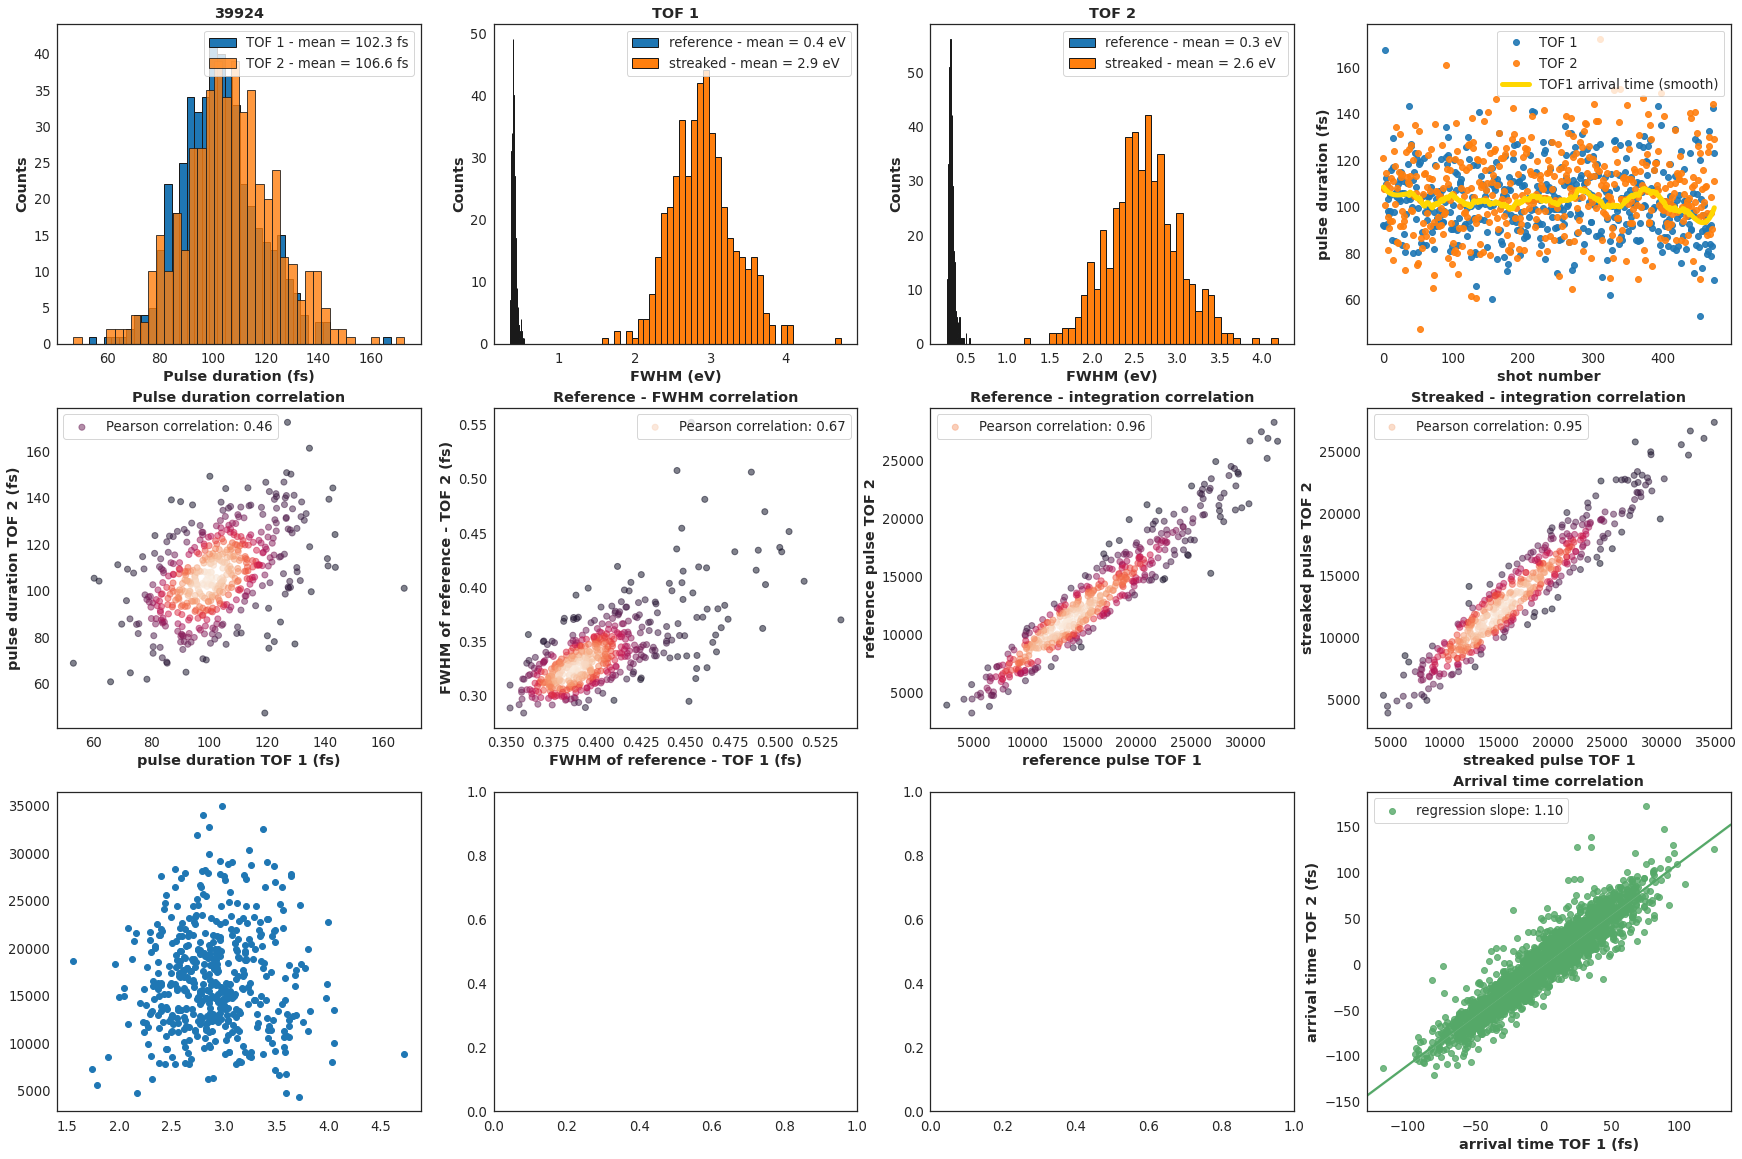

In [143]:
plt.rcParams["figure.figsize"] = [30,20]

def correlation_plotter(t_tof1_inlier,t_tof2_inlier,sigma_ref_list1,sigma_str_list1,sigma_ref_list2,sigma_str_list2,amplitude_ref1,amplitude_ref2,amplitude_str1,amplitude_str2,fit_integ_ref1,fit_integ_ref2,fit_integ_str1,fit_integ_str2,cg1,cg2,str_slope_tof1,str_slope_tof2,run_number):


    #colors = np.linspace(0,len(tof1_duration),len(tof1_duration))
    plt.subplot(3, 4, 1, aspect='auto')
    plt.hist(t_tof1_inlier,bins=40, edgecolor='k',label="TOF 1 - mean = %s fs" % round(np.nanmean(t_tof1_inlier),1))
    plt.hist(t_tof2_inlier,bins=40, edgecolor='k', alpha=0.8,label="TOF 2 - mean = %s fs" % round(np.nanmean(t_tof2_inlier),1))
    plt.xlabel('Pulse duration (fs)', fontweight='bold')
    plt.ylabel('Counts', fontweight='bold')
    plt.title(run_number, fontweight='bold')
    plt.legend()

    plt.subplot(3, 4, 2, aspect='auto')
    plt.hist(sigma_ref_list1, bins=40,edgecolor='k', label='reference - mean = %s eV' % round(np.nanmean(sigma_ref_list1),1))
    plt.hist(sigma_str_list1, bins=40,edgecolor='k', label='streaked - mean = %s eV' % round(np.nanmean(sigma_str_list1),1))
    plt.legend(loc='upper right')
    plt.ylabel('Counts', fontweight='bold')
    plt.xlabel('FWHM (eV)', fontweight='bold')
    plt.title('TOF 1', fontweight='bold')

    plt.subplot(3, 4, 3, aspect='auto')
    plt.hist(sigma_ref_list2, bins=40, edgecolor='k', label='reference - mean = %s eV' % round(np.nanmean(sigma_ref_list2),1))
    plt.hist(sigma_str_list2, bins=40, edgecolor='k', label='streaked - mean = %s eV' % round(np.nanmean(sigma_str_list2),1))
    plt.legend(loc='upper right')
    plt.ylabel('Counts', fontweight='bold')
    plt.xlabel('FWHM (eV)', fontweight='bold')
    plt.title('TOF 2', fontweight='bold')

    plt.subplot(3, 4, 4, aspect='auto')
    xy = np.vstack([t_tof1_inlier,t_tof2_inlier])
    colors = gaussian_kde(xy)(xy)
    plt.plot(t_tof1_inlier,'o',label='TOF 1', alpha=0.9)
    plt.plot(t_tof2_inlier,'o',label='TOF 2', alpha=0.9)
    plt.plot(scipy.signal.savgol_filter(t_tof1_inlier,71,3),label="TOF1 arrival time (smooth)",color ='gold', alpha=1,linewidth=5.0)
    plt.xlabel('shot number', fontweight='bold')
    plt.ylabel('pulse duration (fs)', fontweight='bold')
    plt.legend()

    plt.subplot(3, 4, 5, aspect='auto')
    r,p = stats.pearsonr(t_tof1_inlier,t_tof2_inlier)
    plt.scatter(t_tof1_inlier,t_tof2_inlier, s = None, c = colors, alpha=0.5, label=f"Pearson correlation: {r:.2f}")
    plt.title('Pulse duration correlation', fontweight='bold')
    plt.xlabel('pulse duration TOF 1 (fs)', fontweight='bold')
    plt.ylabel('pulse duration TOF 2 (fs)', fontweight='bold')
    plt.legend()

    plt.subplot(3, 4, 6, aspect='auto')
    xy = np.vstack([sigma_ref_list1,sigma_ref_list2])
    colors = gaussian_kde(xy)(xy)
    r,p = stats.pearsonr(sigma_ref_list1,sigma_ref_list2)
    plt.scatter(sigma_ref_list1,sigma_ref_list2, s = None, c = colors, alpha=0.5, label=f"Pearson correlation: {r:.2f}")
    plt.title('Reference - FWHM correlation', fontweight='bold')
    plt.xlabel('FWHM of reference - TOF 1 (fs)', fontweight='bold')
    plt.ylabel('FWHM of reference - TOF 2 (fs)', fontweight='bold')
    plt.legend()
    
    plt.subplot(3,4,7)
    xy = np.vstack([fit_integ_ref1,fit_integ_ref2])
    colors = gaussian_kde(xy)(xy)
    r,p = stats.pearsonr(fit_integ_ref1,fit_integ_ref2)
    plt.scatter(fit_integ_ref1,fit_integ_ref2, s = None, c = colors, alpha=0.5, label=f"Pearson correlation: {r:.2f}")
    plt.title('Reference - integration correlation', fontweight='bold')
    plt.xlabel('reference pulse TOF 1', fontweight='bold')
    plt.ylabel('reference pulse TOF 2', fontweight='bold')
    plt.legend()

    plt.subplot(3,4,8)
    xy = np.vstack([fit_integ_str1,fit_integ_str2])
    colors = gaussian_kde(xy)(xy)
    r,p = stats.pearsonr(fit_integ_str1,fit_integ_str2)
    plt.scatter(fit_integ_str1,fit_integ_str2, s = None, c = colors, alpha=0.5, label=f"Pearson correlation: {r:.2f}")
    plt.title('Streaked - integration correlation', fontweight='bold')
    plt.xlabel('streaked pulse TOF 1', fontweight='bold')
    plt.ylabel('streaked pulse TOF 2', fontweight='bold')
    plt.legend()
    

    plt.subplot(3, 4, 9, aspect='auto')
    plt.plot(sigma_str_list1,fit_integ_str1,'o')
    plt.xlabel('Streaked pulse integration')
    plt.ylabel('Sigma - Streaked pulse')
    #xy = np.vstack([sigma_str_list1,sigma_str_list2])
    #colors = gaussian_kde(xy)(xy)
    #r,p = stats.pearsonr(sigma_str_list1,sigma_str_list2)
    #plt.scatter(sigma_str_list1,sigma_str_list2, s = None, c = colors, alpha=0.5, label=f"Pearson correlation: {r:.2f}")
    #plt.title('Streaked - FWHM correlation', fontweight='bold')
    #plt.xlabel('FWHM of streaked - TOF 1 (fs)', fontweight='bold')
    #plt.ylabel('FWHM of streaked - TOF 2 (fs)', fontweight='bold')
    #plt.legend()
    
    plt.subplot(3, 4, 10, aspect='auto')
    #xy = np.vstack([amplitude_ref1,amplitude_ref2])
    #colors = gaussian_kde(xy)(xy)
    #r,p = stats.pearsonr(amplitude_ref1,amplitude_ref2)
    #plt.scatter(amplitude_ref1,amplitude_ref2, s = None, c = colors, alpha=0.5, label=f"Pearson correlation: {r:.2f}")
    #plt.title('Reference - amplitude correlation', fontweight='bold')
    #plt.xlabel('reference amplitude TOF 1', fontweight='bold')
    #plt.ylabel('reference amplitude TOF 2', fontweight='bold')
    #plt.legend()

    plt.subplot(3, 4, 11, aspect='auto')
    #xy = np.vstack([amplitude_str1,amplitude_str2])
    #colors = gaussian_kde(xy)(xy)
    #r,p = stats.pearsonr(amplitude_str1,amplitude_str2)
    #plt.scatter(amplitude_str1,amplitude_str2, s = None, c = colors, alpha=0.5, label=f"Pearson correlation: {r:.2f}")
    #plt.title('Streaked - amplitude correlation', fontweight='bold')
    #plt.xlabel('streaked amplitude TOF 1', fontweight='bold')
    #plt.ylabel('streaked amplitude TOF 2', fontweight='bold')
    #plt.legend()

    plt.subplot(3,4,12)
    sns.set(style='white', font_scale=1.2)
    slope, intercept, r, p, stderr = scipy.stats.linregress(cg1-np.mean(cg1), np.mean(cg2)-cg2)
    sns.regplot(cg1-np.mean(cg1), np.mean(cg2)-cg2, color="g", ci=68, truncate=False, label=f"regression slope: {slope:.2f}")
    plt.legend()
    plt.title('Arrival time correlation', fontweight='bold')
    plt.xlabel('arrival time TOF 1 (fs)', fontweight='bold')
    plt.ylabel('arrival time TOF 2 (fs)', fontweight='bold')

correlation_plotter(t_tof1_inlier,t_tof2_inlier,sigma_ref_list_inlier1,sigma_str_list_inlier1,sigma_ref_list_inlier2,sigma_str_list_inlier2,
                         amplitude_ref_inlier1,amplitude_ref_inlier2,amplitude_str_inlier1,amplitude_str_inlier2,fit_integ_ref_inlier1,fit_integ_ref_inlier2,fit_integ_str_inlier1,fit_integ_str_inlier2,center_of_gravity1,center_of_gravity2,str_slope_tof1,str_slope_tof2,run_number)   

#center_of_gravity1-np.mean(center_of_gravity1),np.mean(center_of_gravity2)-center_of_gravity2
#plt.savefig(f"{run_number}_correlation_plots.png")
plt.show()

plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
plt.rcParams["figure.figsize"] = [10, 5]

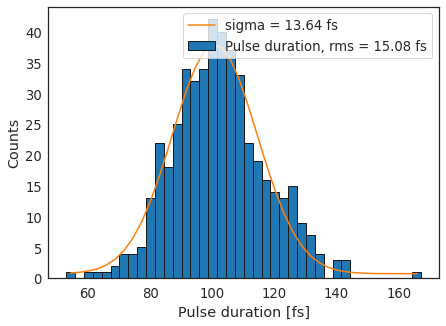

In [44]:
duration_resolution = np.std(t_tof1_inlier)

plt.rcParams["figure.figsize"] = [7, 5]
bin_heights, bin_borders, _ = plt.hist(t_tof1_inlier,bins=40, edgecolor='k', label='Pulse duration, rms = %s fs'%round(duration_resolution,2))
#plt.hist(t_tof2_inlier,bins=40, edgecolor='k', alpha=0.8,label="TOF 2 - mean = %s fs" % round(np.nanmean(t_tof2_inlier),1))
plt.xlabel('Pulse duration [fs]')
plt.ylabel('Counts')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
[H_hist, A_hist, x0_hist, sigma_hist], _ = sfun.gauss_fit(bin_centers, bin_heights, np.max(bin_heights), bin_centers[np.argmax(bin_heights)], 2)
#plt.plot(bin_centers,sfun.gauss(bin_centers, H_hist, A_hist, x0_hist, sigma_hist), label='FWHM = %s fs'%round(sigma_hist*2.3548,2))
plt.plot(bin_centers,sfun.gauss(bin_centers, H_hist, A_hist, x0_hist, sigma_hist), label='sigma = %s fs'%round(sigma_hist,2))
plt.legend()
plt.savefig(f"{run_number}_pulse_duration.png",dpi=300)
plt.show()

In [46]:
/np.min(t_tof1_inlier)

52.98907554760838

### Extra cells
### Finding the Best __threshold__ for __relative arrival time__
<a id="rel_arrival"></a>

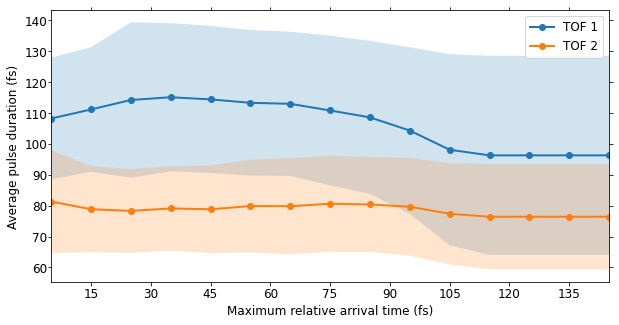

In [36]:
# in this cell I change the max value for the relative arrival time and calculate the pulse duration

min_rel_arrival = 5
max_rel_arrival = 150

rel_arrival,t_tof1_list,t_tof2_list,t_tof1_err,t_tof2_err = sfun.rel_arrival_time(
    min_rel_arrival,max_rel_arrival,energy_axis,energy_axis2,no_bck,no_bck2,str_slope_tof1,str_slope_tof2,reference_signal,reference_signal2,streaked_signal,streaked_signal2)

fig, ax = plt.subplots()
plt.plot(rel_arrival, t_tof1_list,'-o',label="TOF 1")
plt.plot(rel_arrival, t_tof2_list,'-o',label="TOF 2")
plt.fill_between(rel_arrival, np.add(t_tof1_list,t_tof1_err),np.subtract(t_tof1_list,t_tof1_err), alpha=0.2)
plt.fill_between(rel_arrival, np.add(t_tof2_list,t_tof2_err),np.subtract(t_tof2_list,t_tof2_err), alpha=0.2)
ax.set_xlabel('Maximum relative arrival time (fs)')
ax.set_ylabel('Average pulse duration (fs)')
ax.xaxis.set_major_locator(MaxNLocator(11)) 
ax.legend()
plt.xlim(np.min(rel_arrival),np.max(rel_arrival))
plt.savefig(f"{run_number}_max_arrival_time_raw.png")
plt.show()


### Ploting the __fitting parameters__
<a id="fit_param"></a>

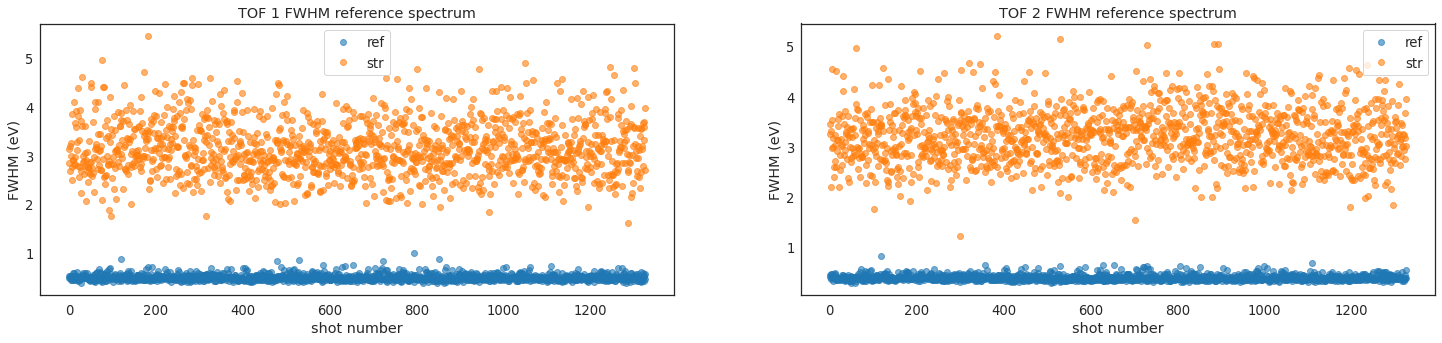

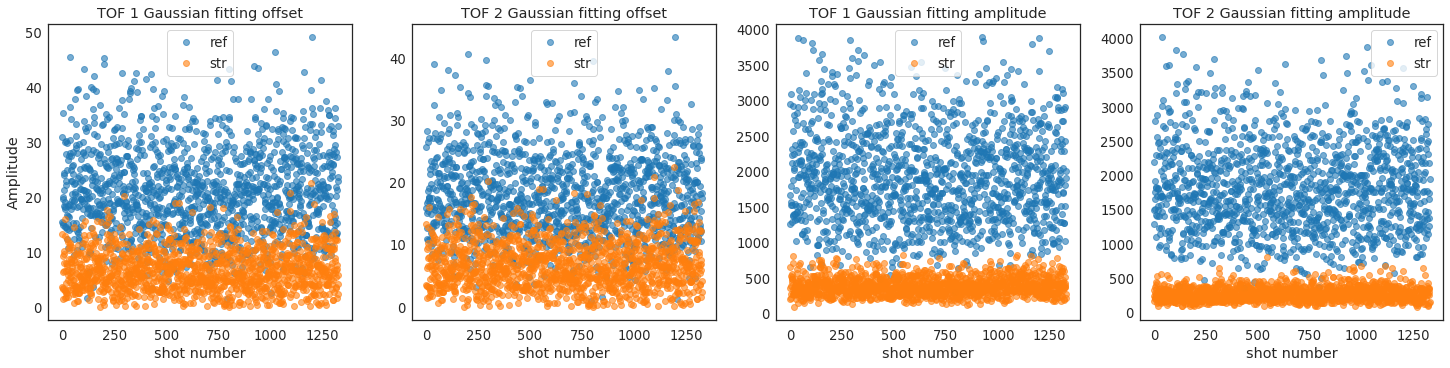

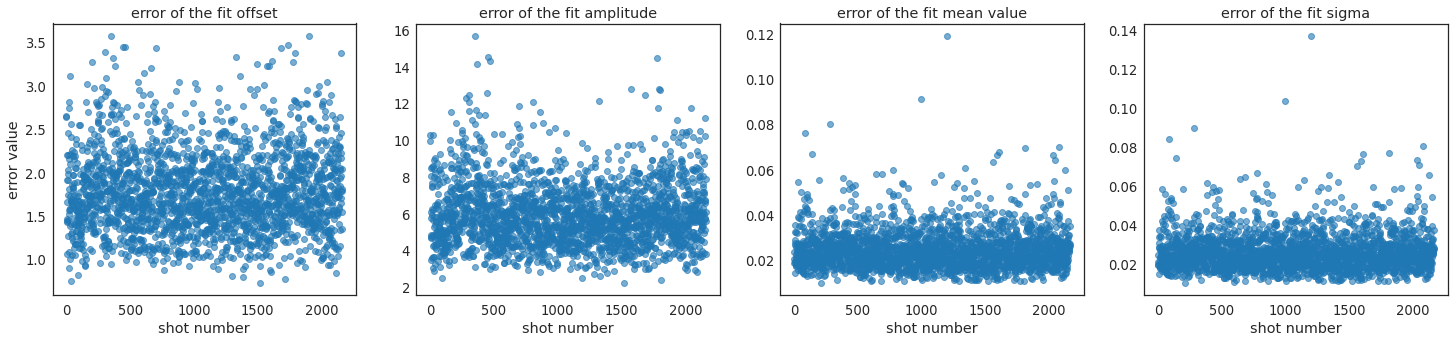

In [14]:
plt.rcParams["figure.figsize"] = [25,5]
sfun.fwhm_plotter(sigma_ref_list_inlier1,sigma_ref_list_inlier2,sigma_str_list_inlier1,sigma_str_list_inlier2)
plt.rcParams["figure.figsize"] = [25,12]    
sfun.gaussian_amp_base_plotter(base_ref_list_inlier1,base_ref_list_inlier2,base_str_list_inlier1,base_str_list_inlier1,amplitude_ref_inlier1,amplitude_ref_inlier2,amplitude_str_inlier1,amplitude_str_inlier2)
plt.rcParams["figure.figsize"] = [25,5]
sfun.error_plotter(err_str1) #err_ref1 err_ref2 err_str2 can be plotted as well
plt.rcParams["figure.figsize"] = [10, 5]

### Ploting __fitting curves__
<a id="fit_curve"></a>

inlier index: 0


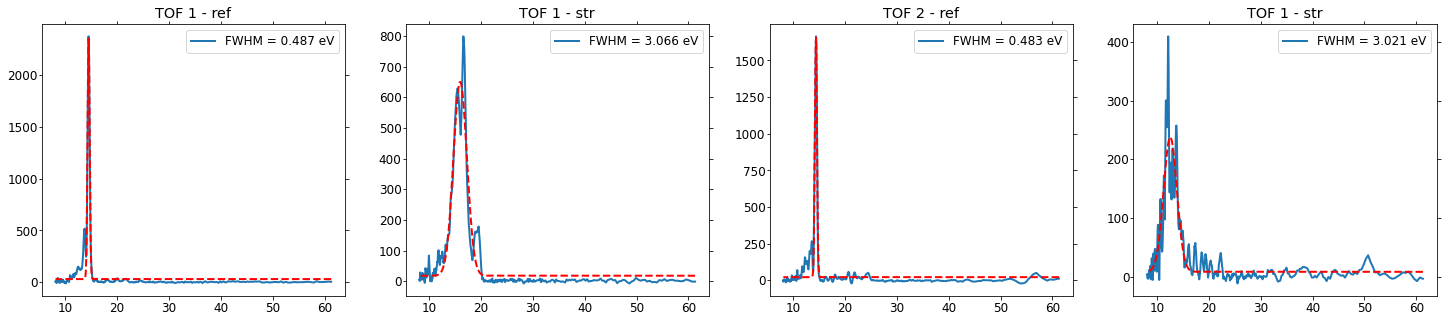

------------------------------------------------------------------------------
inlier index: 1


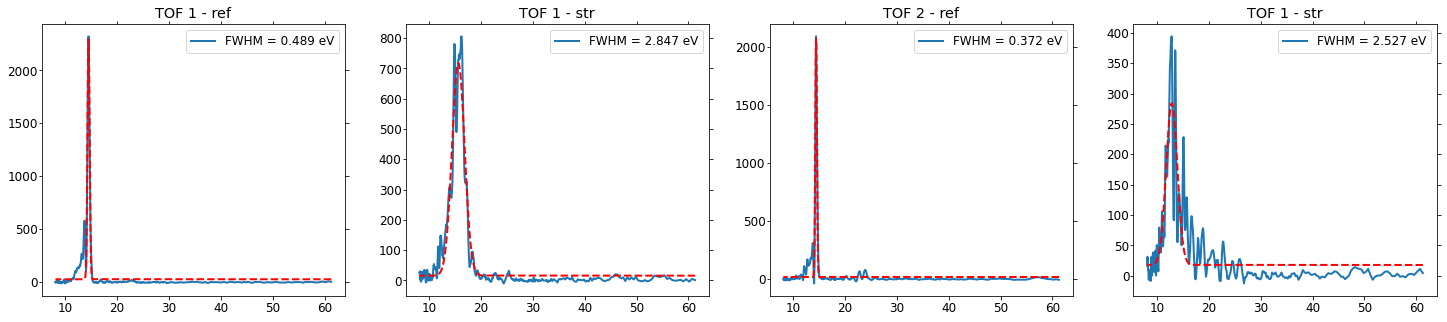

------------------------------------------------------------------------------
inlier index: 2


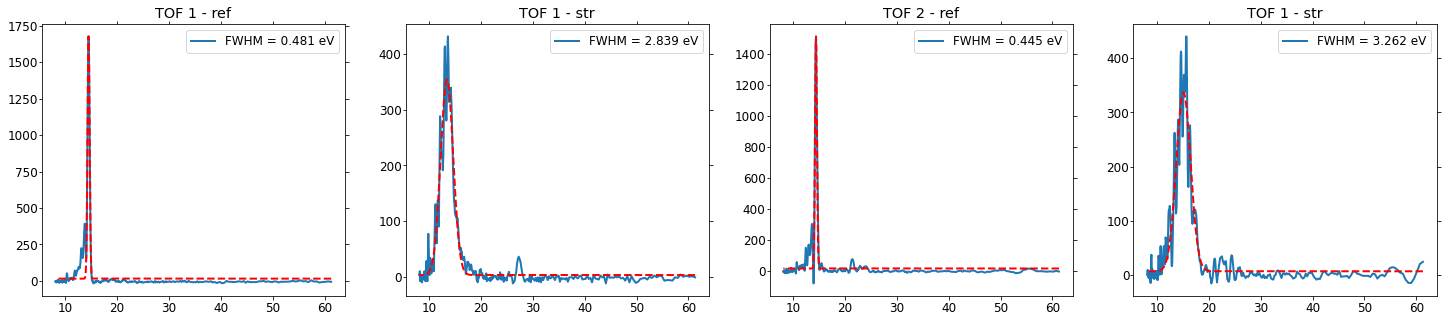

------------------------------------------------------------------------------
inlier index: 3


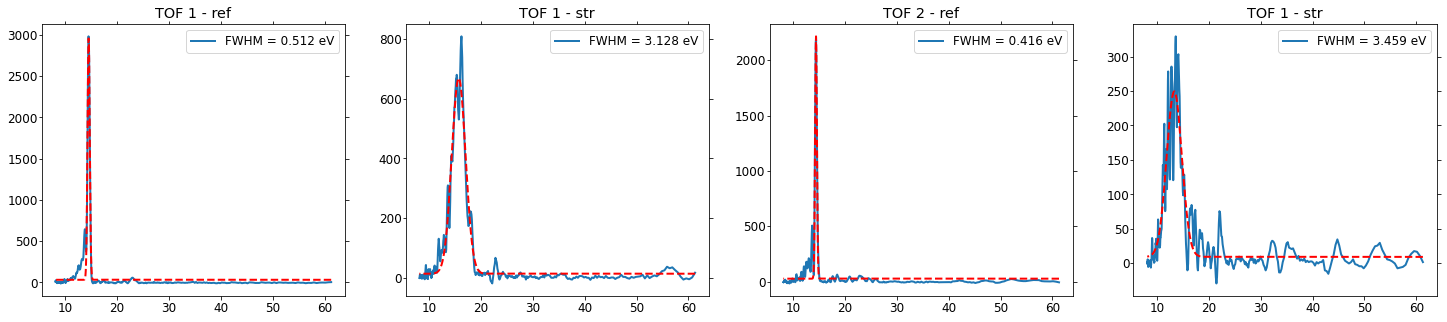

------------------------------------------------------------------------------
inlier index: 4


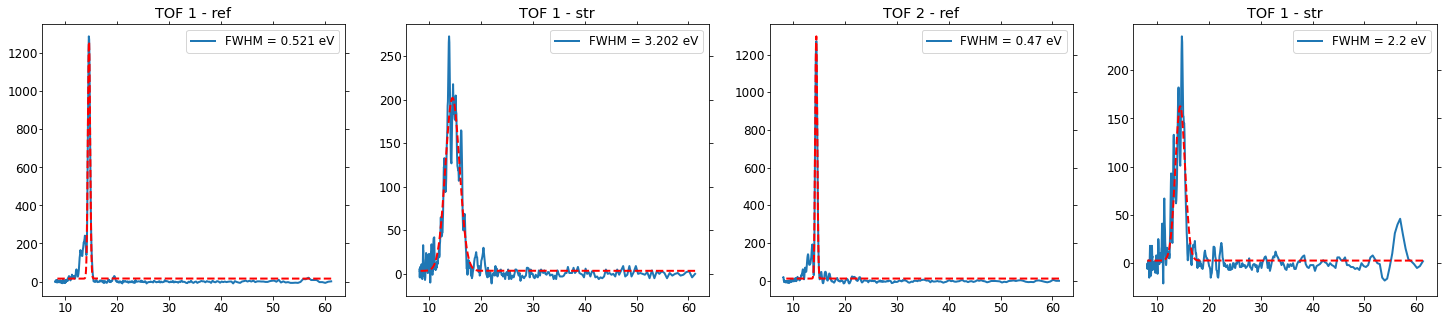

------------------------------------------------------------------------------
inlier index: 5


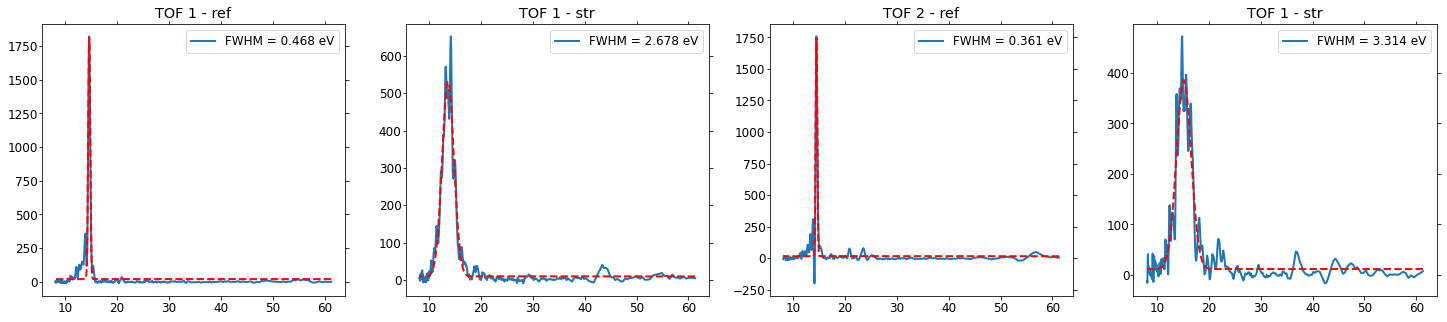

------------------------------------------------------------------------------
inlier index: 6


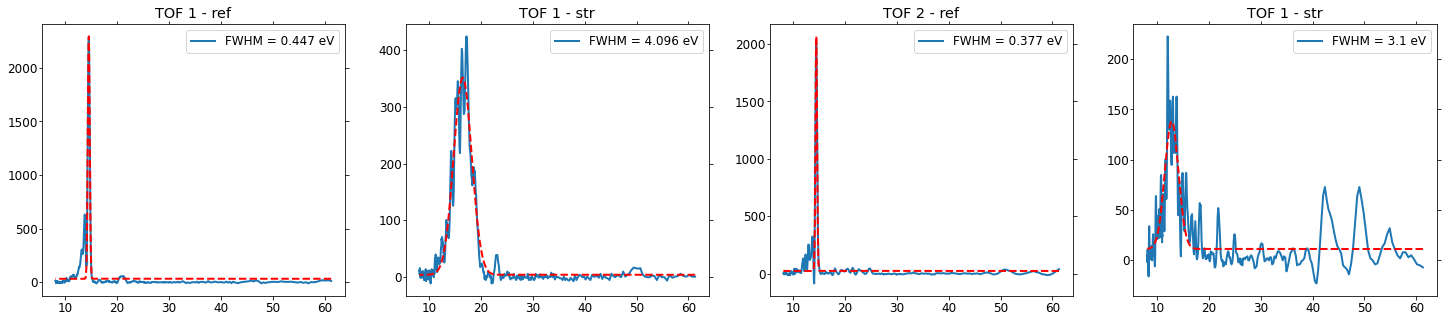

------------------------------------------------------------------------------
inlier index: 7


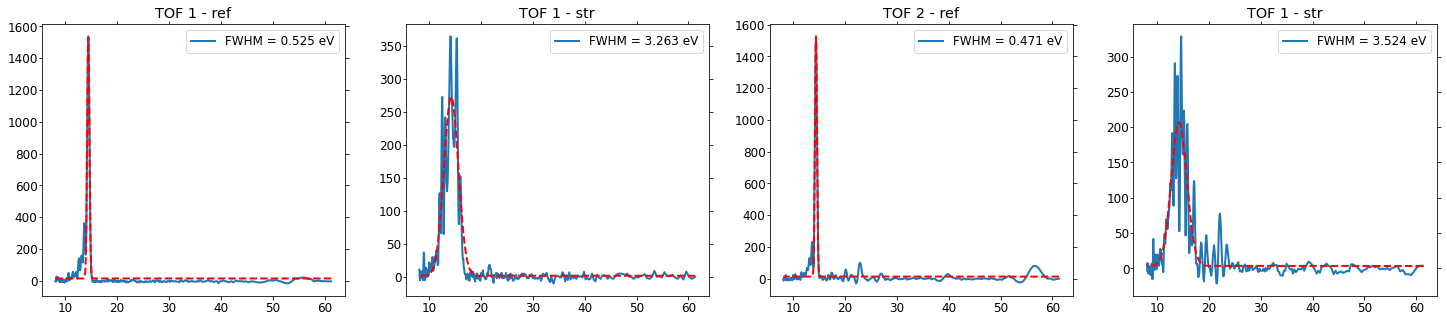

------------------------------------------------------------------------------
inlier index: 8


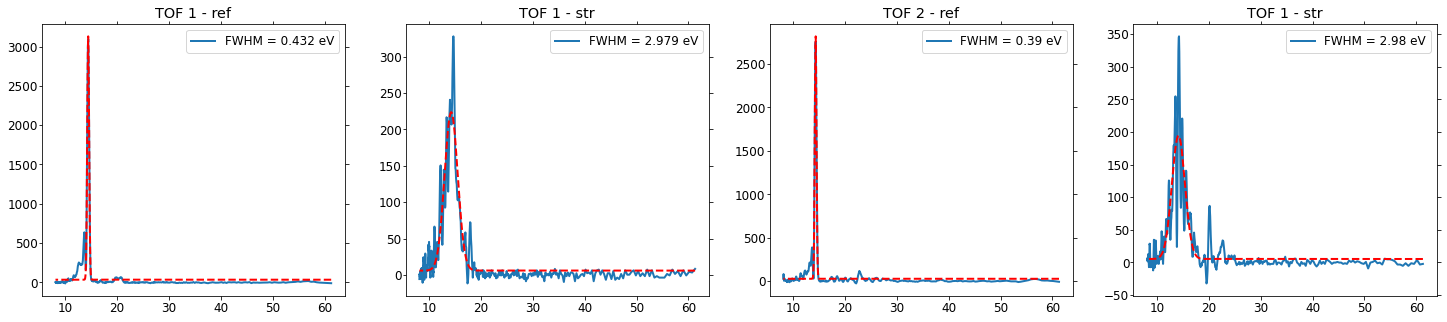

------------------------------------------------------------------------------
inlier index: 9


KeyboardInterrupt: 

In [12]:
plt.rcParams["figure.figsize"] = (25,5)

#len(reference_signal[1,:])
for l in range(0,len(reference_signal[1,:])):
    
    if inliers_index[l]>0:
        print("inlier index:",l)

        #TOF 1 ---------------------------------------
        plt.subplot(1, 4, 1)
        sfun.fitting_plotter(reference_signal,energy_axis,amp_ref1,mean_ref1,l,"TOF 1 - ref")
        plt.subplot(1, 4, 2)
        sfun.fitting_plotter(streaked_signal,energy_axis,amp_str1,mean_str1,l,"TOF 1 - str")
        #TOF 2 ---------------------------------------
        plt.subplot(1, 4, 3)
        sfun.fitting_plotter(reference_signal2,energy_axis2,amp_ref2,mean_ref2,l,"TOF 2 - ref")
        plt.subplot(1, 4, 4)
        sfun.fitting_plotter(streaked_signal2,energy_axis2,amp_str2,mean_str2,l,"TOF 1 - str")
        plt.show()
        print("------------------------------------------------------------------------------")

plt.rcParams["figure.figsize"] = [10,5]

plt.rcParams["figure.figsize"] = [10, 5]### Traces
<a id="traces"></a>

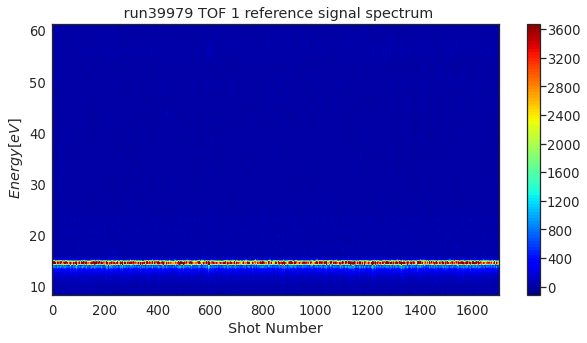

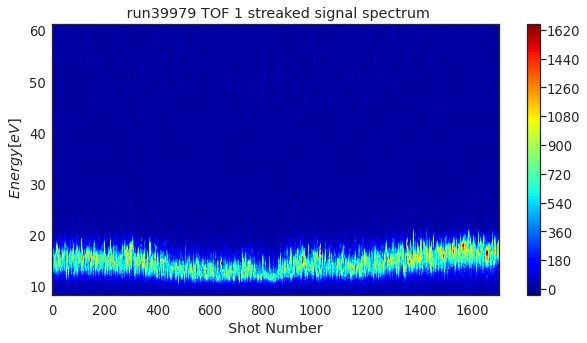

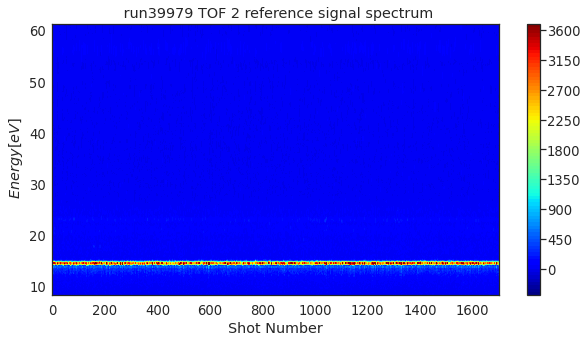

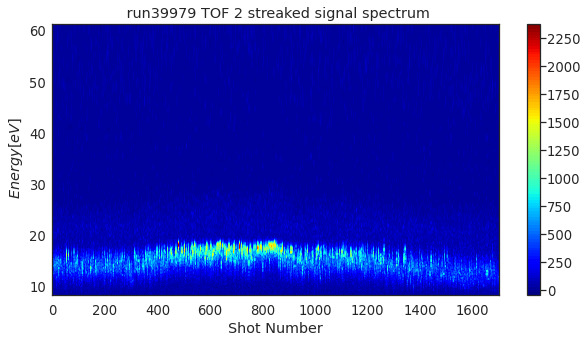

In [51]:
##### TOF1
sfun.trace_plotter(reference_signal[:,0:3500],energy_axis,run_number,"TOF 1 reference signal")
sfun.trace_plotter(streaked_signal[:,0:3500],energy_axis,run_number,"TOF 1 streaked signal")
##### TOF2
sfun.trace_plotter(reference_signal2[:,0:3500],energy_axis2,run_number,"TOF 2 reference signal")
sfun.trace_plotter(streaked_signal2[:,0:3500],energy_axis2,run_number,"TOF 2 streaked signal")

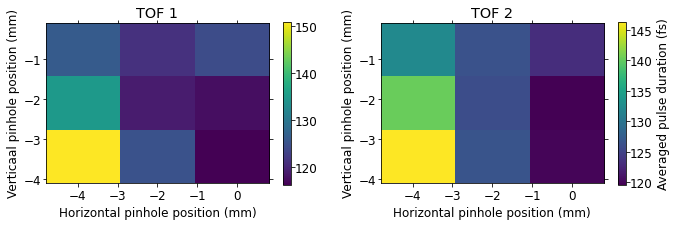

In [105]:
plt.rcParams["figure.figsize"] = (11,3)

pinhole_TOF1 = [[126.1, 121.2, 124.2],[134.9, 118.8, 117.5],[150.9, 125, 116.2]]
pinhole_TOF2 = [[132.3, 126.3, 123.1],[140.3, 125.9, 119.6],[146.4, 126.6, 120]]

x = [-4.8, -2.8, 0.8]
y = [-4.1, -2.1, -0.1]
extent = np.min(x), np.max(x), np.min(y), np.max(y)

plt.subplot(1, 2, 1)
plt.title('TOF 1')
plt.imshow(pinhole_TOF1,extent=extent)
plt.ylabel('Verticaal pinhole position (mm)')
plt.xlabel('Horizontal pinhole position (mm)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('TOF 2')
plt.imshow(pinhole_TOF2,extent=extent)
plt.ylabel('Verticaal pinhole position (mm)')
plt.xlabel('Horizontal pinhole position (mm)')

cbar = plt.colorbar()
cbar.set_label('Averaged pulse duration (fs)')
plt.savefig("pinhole_scan.png", bbox_inches='tight', dpi=300)
plt.show()

In [11]:
import numpy
img = numpy.zeros((10,10,3), dtype=numpy.int)  # Black RGB image (10x10)
img[5,2] = [255, 255, 255]
print(img.reshape((img.shape[0]*img.shape[1], 3)).max(axis=0))

[255 255 255]


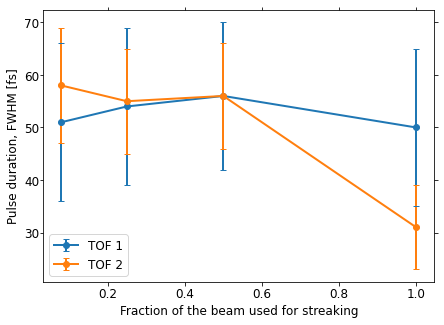

In [3]:
#1 Sep - cutting mirror
plt.rcParams["figure.figsize"] = [7, 5]
beam_fraction=[1,0.5,0.25,0.08]
TOF1_duration=[50,56,54,51]
TOF2_duration=[31,56,55,58]
TOF1_err=[15,14,15,15]
TOF2_err=[8,10,10,11]
plt.errorbar(beam_fraction, TOF1_duration, yerr=TOF1_err, marker='o',capsize=3,label="TOF 1")
plt.errorbar(beam_fraction, TOF2_duration, yerr=TOF2_err, marker='o',capsize=3,label="TOF 2")
plt.xlabel("Fraction of the beam used for streaking")
plt.ylabel("Pulse duration, FWHM [fs]")
plt.legend()
plt.savefig("cutting_mirror.png", bbox_inches='tight', dpi=300)
plt.show()

In [20]:
try:
    os.mkdir(save_path + run_number +f'_file{file_num}/')
except OSError:
    pass
os.chdir(save_path + run_number +f'_file{file_num}/')